<div style="text-align:right">Peter Norvig<br>21 March 2018</div>

# `xkcd` Name Dominoes

The March 21, 2018 `xkcd` comic number 1970 was [Name Dominoes](https://xkcd.com/1970/): domino tiles laid out in a legal array,
but with each tile having names of famous poeple rather than numbers. In regular [dominoes](https://en.wikipedia.org/wiki/Dominoes), each tile has two halves, and a tile can be legally placed only if  one half is adjacent to another tile with the same number/name, and neither half is adjacent to any tile with a different number/name. (The very first tile in a game has no adjacent tiles, so it can be placed anywhere.) I will write a function to lay out dominoes in a random, legal array.  I'll start with two key data structures:

- **`Tile`**: a tile is a 2-element tuple, like `('Tim', 'Cook')`, indicating the two halves.
- **`Board(n)`**: Creates an [n × n] 2-dimensional array of locations; each location holds as a value one half of a tile, or it can be `empty`, or it can be a `border`, meaning nothing can be placed there.


In [1]:
empty  = '  '
border = '--'

Tile = tuple

class Board(list):
    "A board is a 2d array of values."
    
    def __init__(self, n): 
        "Initialize an [n × n] array of `empty`, surrounded by `off`"
        top = bot = [border] * (n + 2)
        line = [border] + ([empty] * n) + [border]
        self.extend([top] + [list(line) for _ in range(n)] + [bot])
        
    def get(self, loc): return self[loc[1]][loc[0]]
    
    def put(self, loc, value): self[loc[1]][loc[0]] = value
        
tiles1 = [('Bo', 'Ja'), ('Ja', 'Po'), ('Ja', 'Ry'), ('Ry', 'Ke'), ('Gr', 'Ke'), ('Gr', 'Ho')]

In [2]:
Board(4)

[['--', '--', '--', '--', '--', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '  ', '  ', '  ', '  ', '--'],
 ['--', '--', '--', '--', '--', '--']]

Now I need a strategy to fill the board with tiles, legally.  I will randomly place dominoes one at a time, and I will *not* consider removing a tile from the board and backtracking; this is a greedy search. Some more concepts:

- **`frontier`**: I'll maintain a *frontier*, a set of locations that are adjacent to tiles on the board, and thus are candidates for placing new tiles.
- **`dominoes(tiles)`**: places a random tile for the first tile, then repeatedly calls `place1` to legally place an additional tile, stopping when either there is no `frontier` left (meaning no place to put a tile) or no `tiles` left to place.
- **`place1(tiles, board, frontier)`**: find a location in the frontier, such that some tile can legally put one of its halves there, and the other half on an adjacent location; when found, `put` the tile there, and remove it from `tiles`.
- **`legal(value, loc, board)`**: a value can be placed if the location is empty, and the value matches all the neighboring location values.
- **`legal_match(value, nbrval)`**: a value matches if the neighbor is empty or a border, or is equal to the value.
- **`neighbors(loc)`**: returns the four neighbors of a location.
- **`put(board, loc0, loc1, tile, frontier)`**: places a tile on the board, it accomplishes this by making two calls to the board's `put` method, one for each half of the tile. The `put` function also updates the `frontier` to say that the just-covered locations are no longer in the frontier, but the empty neighbors of the tile are.
- **`shuffle(sequence)`**: used to randomize lists; calls `random.shuffle` and returns the result.

In [3]:
import random

def dominoes(tiles, n=24):
    "Place as many tiles on board as possible, legally and randomly."
    tiles    = shuffle(list(tiles))
    board    = Board(n)
    frontier = set()
    m        = n // 2
    put(board, (m, m), (m, m + 1), tiles.pop(), frontier) # Place first tile
    while tiles and frontier:
        place1(tiles, board, frontier)
    return board
          
def place1(tiles, board, frontier):
    "Randomly place one tile on board, on some frontier location and an adjacent square."
    for loc0 in shuffle(frontier):
        frontier.discard(loc0)
        for tile in shuffle(tiles):
            for (v, w) in [tile, tile[::-1]]:
                if legal(v, loc0, board):
                    for loc1 in shuffle(neighbors(loc0)):
                        if legal(w, loc1, board):
                            put(board, loc0, loc1, [v, w], frontier)
                            tiles.remove(tile)
                            return  
                        
def legal(value, loc, board):
    "Is it legal to place this value on this location on board?"
    return (board.get(loc) is empty and
            all(legal_match(value, board.get(nbr)) 
                for nbr in neighbors(loc)))

def legal_match(value, nbrval):
    "Does this value match the neighbor's value?"
    return nbrval in (empty, border, value)
                
def neighbors(loc):
    "Neighbors of this location."
    x, y = loc
    return ((x, y+1), (x, y-1), (x+1, y), (x-1, y)) 

def put(board, loc0, loc1, tile, frontier): 
    "Place the tile across the two locations, and update frontier."
    board.put(loc0, tile[0])
    board.put(loc1, tile[1])
    frontier -= {loc0, loc1}
    frontier |= {loc for loc in neighbors(loc0) + neighbors(loc1)
                 if board.get(loc) is empty}
                            
def shuffle(seq):
    "Return seq as a shuffled list."
    if not isinstance(seq, list): seq = list(seq)
    random.shuffle(seq)
    return seq
    
dominoes(tiles1, 5)

[['--', '--', '--', '--', '--', '--', '--'],
 ['--', 'Ho', '  ', 'Po', 'Ja', '  ', '--'],
 ['--', 'Gr', 'Gr', '  ', 'Ja', 'Bo', '--'],
 ['--', '  ', 'Ke', '  ', 'Ja', '  ', '--'],
 ['--', '  ', 'Ke', 'Ry', 'Ry', '  ', '--'],
 ['--', '  ', '  ', '  ', '  ', '  ', '--'],
 ['--', '--', '--', '--', '--', '--', '--']]

# Pretty Output

There are two problems with this output. One, it is ugly. Two, I can't easily tell where each domino is: when three names come together, which of the outside ones go with the middle one?  To fix those two problems I will:

- Use `matplotlib` to plot a less-ugly display, by defining `plot_board(board)`.
- Modify the `Board` class and the `put` function so that the board maintains a list of `boxes` that surround each tile once it is placed on the board.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_board(board, figsize=6):
    plt.figure(figsize=(figsize, figsize))
    plt.axis('off')  
    plt.axis('equal')
    for (x0, y0, x1, y1) in board.boxes:
        plt.plot([x0, x1, x1, x0, x0], 
                 [y0, y0, y1, y1, y0], 'k-')
    for (y, row) in enumerate(board):
        for (x, val) in enumerate(row):
            if val is not border:
                plt.text(x + 0.5, y + 0.3, val.replace('-', ' '),
                         ha='center', fontsize=8)
                
class Board(list):
    "A board is a 2d array of values."
    
    def __init__(self, n): 
        "Initialize an [n × n] array of `empty`, surrounded by `off`"
        top = bot = [border] * (n + 2)
        line = [border] + ([empty] * n) + [border]
        self.extend([top] + [list(line) for _ in range(n)] + [bot])
        self.boxes = []
        
    def get(self, loc): return self[loc[1]][loc[0]]
    
    def put(self, loc, value): self[loc[1]][loc[0]] = value
        
        
def put(board, loc0, loc1, tile, frontier): 
    "Place the tile across the two locations, and update frontier."
    board.put(loc0, tile[0])
    board.put(loc1, tile[1])
    frontier -= {loc0, loc1}
    frontier |= {loc for loc in neighbors(loc0) + neighbors(loc1)
                 if board.get(loc) is empty}
    (x0, y0), (x1, y1) = loc0, loc1
    board.boxes.append((min(x0, x1), min(y0, y1), max(x0, x1) + 1, max(y0, y1) + 1))

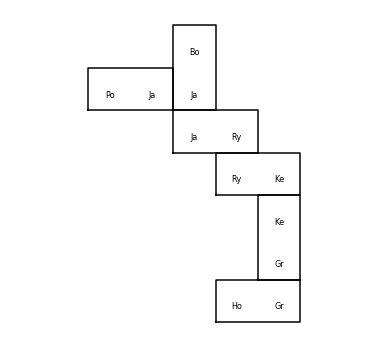

In [5]:
plot_board(dominoes(tiles1))

# All the Names

Now let's try **all** the names from `xkcd 1970`, as reported 
by [explainxkcd](http://www.explainxkcd.com/wiki/index.php/1970:_Name_Dominoes), with a few typo corrections:

In [6]:
def split_names(text):
    "For each line of text, create a Tile of ('First Name(s)', 'Lastname')."
    return [name.rpartition(' ')[0::2]
            for name in text.strip().splitlines()]
            
tiles1970 = split_names("""
Christian Campbell
Neve Campbell
Joe McCarthy
Eugene McCarthy
Gene Vincent
Gene Kelly
Kate Hudson
Rock Hudson
Gordon Brown
James Brown
Jon Brown
John Howard
Columbo
Chris Columbus
Christopher Columbus
Naomi Campbell
Joseph Campbell
Joseph Smith
Frank Vincent
John Kelly
Katherine Johnson
The Rock
Chris Rock
Chris Isaac
James Newton Howard
John Wayne
Howard Stern
Howard Hunt
Chris Hughes
Naomi Watts
Naomi Klein
Kevin Kline
Francis Bacon
Francis Drake
Lyndon Johnson
Oscar the Grouch
Oscar Isaac
Isaac Hayes
Isaac Newton
Wayne Newton
Wayne Knight
Helen Hunt
Helen Hughes
James Watt
James Watt
Kevin Costner
Kevin Bacon
Kevin Love
Lisa Frank
Frank Drake
Drake
Oscar de la Renta
Oscar de la Hoya
Sean Hayes
Wallace Shawn
Wayne Howard
Wayne Brady
James Brady
Tom Brady
Helen Thomas
Tom Hanks
Hank Aaron
Aaron Carter
Stephen James
Will Smith
Kevin Smith
Kein James
Garfield
James Garfield
Warren Buffett
Jimmy Buffett
Warren Beatty
Elizabeth Warren
Earl Warren
Eliabeth Kolbert
Stephen Colbert
George Wallace
Charles Wallace
James Monroe
Marilyn Monroe
Hank Williams
William C. Williams
Steve Harvey
Domino Harvey
Harvey Milk
James Saint James
Etta James
Jim Jones
James Earl Jones
Charlie Parker
Ray Parker
Ray Charles
Charles Manson
Marilyn Manson
Robin Williams
Billy D. Williams
Will Wright
Fats Domino
Bill Clinton
Jimmy John
Tom Jones
Tommy John
Quincy Jones
James Earl Ray
Man Ray
Rachel Ray
Ray Allen
Tim Allen
Tim Cook
Tim Howard
Robin Wright
Wilbur Wright
Fatty Arbuckle
Fat Joe
George Clinton
John Kerry
Kerry Washington
John Irving
John Quincy Adams
John Adams
Amy Adams
Aimee Mann
Super Man
Bat Man
Ayn Rand
Lily Allen
Paul Allen
Ron Howard
Howard Hughes
Joe Kennedy
George Bush
George Wasington
Wasington Irving
Martha Wasington
Ma Rainey
Jack Ma
Super Grover
Jack Black
Rand Paul
Paul Ryan
Paul Simon
Ron Paul
John Hughes
Langston Hughes
John F. Kennedy
Little Richard
Rich Little
Martha Stewart
Yo Yo Ma
Ma Bell
Grover Cleveland Alexander
Grover Cleveland
Jack White
Jack Ryan
Debby Ryan
Carly Simon
Carly Hughes
Charles Evans Hughes
John Williams
Little John
Stuart Little
Potter Stewart
Kristen Stewart
Kristen Bell
Kristen Hooks
Alexander Graham Bell
Franklin Graham
Lloyd Alexander
Meg White
Meg Ryan
Debbie Reynolds
John Reynolds
Carly Fiorina
Grace Lee Boggs
Wade Boggs
William Safire
Prince William
Little Prince
Harry Potter
James Potter
James Hook
James Dean
Aretha Franklin
Frank Lloyd Wright
Barry White
Walter White
Walt Whitman
John Kelly
Grace Lee
Nancy Grace
Garnet
Prince
Prince Felder
Prince Harry
Harry Styles
John Dean
Benjamin Franklin
Harrold Lloyd
Harrold Ford
Betty White
Meg Whitman
Christine Todd Whitman
Megyn Kelly
Grace Kelly
Grace Jones
Jack Nicholson
Jack Ruby
Jack Russel
Harry Fielder
Harry Trueman
Harry Jon Benjamin
John Edward
Benjamin Harrison
Harrison Ford
Henry Ford
Betty Ford
Betty Friedan
Chris Christie
Chris Pratt
Maggie Grace
Grace Hopper
Russel Crowe
Russ Smith
John Smith
Justin Long
John Bel Edwards
John Candy
John Henry
Henry James
Bill James
Chris Cooper
Chris Hemsworth
Chris Evans
Topher Grace
Van Morrison
Sheryl Crow
Sheryl Sandberg
Cameron Crow
Long John Silver
Olivia Newton John
Huey long
John Edwards
Candy Crowley
Aleister Crowley
James Fenimore Cooper
James Cook
Robert Frost
Bob Evans
Evan Tayler Jones
James Cameron
Cam Newton
Cameron Diaz
Huey Newton
Huey Lewis
John Lewis
Jenny Lewis
Ryan Lewis
Burt Reynolds
Alistair Cooke
Alistair Cookie
Cokie Roberts
John Roberts
Robert Johnson
Robert E. Lee
Tommy Lee
Tommy Lee Jones
Etta James
John Oliver
Ryan Reynolds
Alastair Reynolds
""")

len(tiles1970)

270

# Approximate and Partial Matches

The halves of two tiles match if they are an exact match, like "Amy" and "Amy", but also if they are an **approximate match**, like "Amy" and "Aimee". You can manually allow for this with:

     synsets = synonyms("Amy=Aimee, ...")

Another issue is  a **partial match**: "John Smith" is allowed to match "Long John Silver"
because the first name "John" is a piece of the first name "Long John". allowed to match. If you pass in a list of tiles as a second argument to `synsets`, then all the pieces of a first name (if it has more than one piece) will be (individually) made synonyms of the whole first name.

I also update `legal_match` to consult the `synsets` global variable for an approximate or partial match, and to handle a special case: a single names like "Prince" gets represented as the tile `('', 'Prince')`, but we don't want the empty first name of this tile to match the empty first name of "Drake", so we disallow an empty-to-empty match.

In [7]:
import collections

Synset = set

def synonyms(text, tiles=()): 
    "synonyms('a=A, b=B') => dict(a={'a', 'A'}, A={'a', 'A'}, b={'b', 'B'}, B={'b', 'B'}"
    synsets = collections.defaultdict(set)
    # Process `text`
    for text1 in text.split(','):
        synset = Synset(text1.strip().split('='))
        for s in synset:
            synsets[s] |= synset
    # Process `tiles`
    for (first, last) in tiles:
        if ' ' in first:
            for piece in first.split():
                synsets[piece].add(first)
                synsets[first].add(piece)
    return synsets

synsets = synonyms("""
  Amy=Aimee, Cook=Cooke=Cookie=Cokie, Alastair=Alistair, Columbo=Columbus, 
  Safire=Sapphire=Garnet, Garnet=Ruby, Charlie=Charles, Sean=Shawn, 
  Jimmy=James, Man=Mann, Jack=John, Tom=Tommy, Will=William=Williams, 
  Robert=Roberts=Bob, Cam=Cameron, Oliver=Olivia, Edward=Edwards, 
  Rich=Richard, Oscar=Oscar, Frank=Frank, Chris=Christopher=Topher,
  Fat=Fats=Fatty
  """, tiles1970)

def legal_match(value, nbrval):
    "Does this value match the neighbor's value?"
    if value == '' == nbrval: return False
    return (nbrval == value or nbrval is empty or nbrval is border or
            nbrval in synsets[value])

# Random Restart

With many tiles, the program can get stuck before it has placed enough tiles. I could modify the program to *back up* in this case, but it will be easier to just *give up* and start again with an empty board. I can repeat this multiple times, and take the board on which the most tiles were placed. The function `best_dominoes` does this, and optionally plots the result. (I could fit more tiles on a larger square (with smaller tiles), but then the text would overflow the tiles even more than now.)

110 / 270 tiles placed


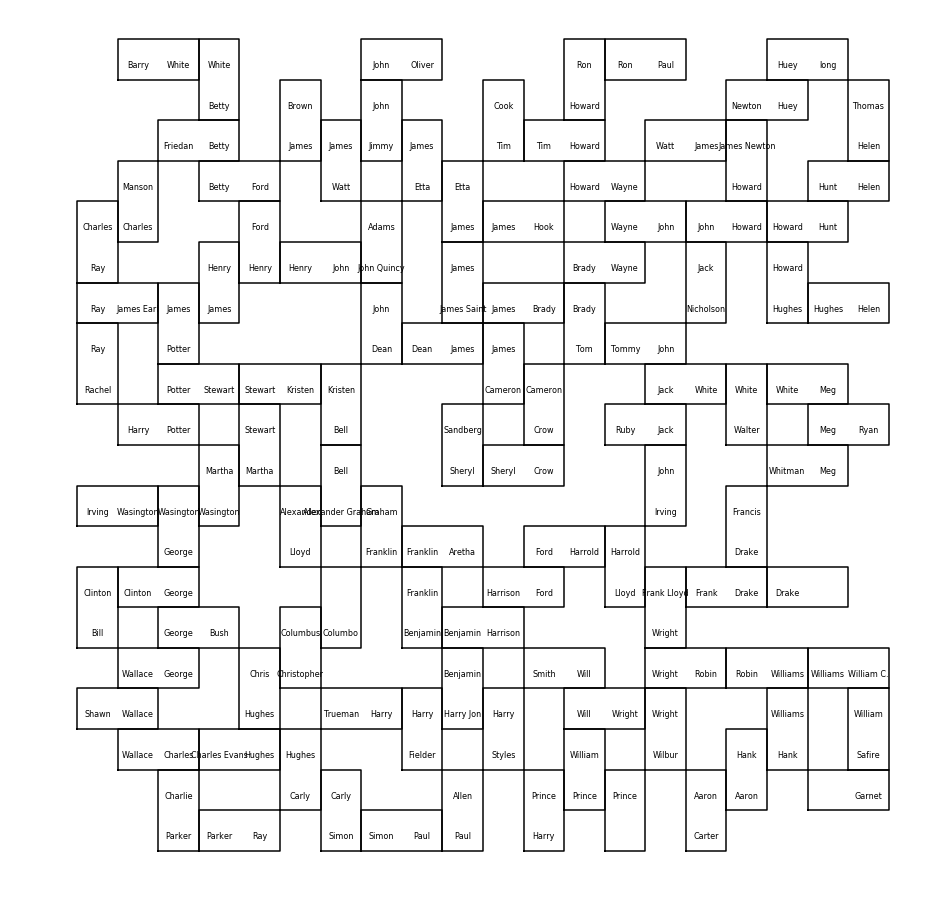

In [8]:
def best_dominoes(tiles, n=20, figsize=16, plot=True, repeat=30):
    board = max((dominoes(tiles, n) for _ in range(repeat)), 
                key=lambda board: len(board.boxes))
    if plot:
        print(len(board.boxes), '/', len(tiles), 'tiles placed')
        plot_board(board, figsize)
    else:
        return board

best_dominoes(tiles1970)